# MRI reconstruction from multicoil data

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/ConvDecoder/

/gdrive/MyDrive/ConvDecoder


In [1]:
import nibabel as nib
path= 'HCP_mgh_1001_MR_MPRAGE_GradWarped_and_Defaced_Br_20140919084711597_S227198_I444246.nii'
img1 = nib.load(path)

In [3]:
!pip install runstats
!pip install pytorch_msssim
!pip install pytorch-lightning==0.7.5
!pip install test-tube
!pip install Pillow

  Created wheel for runstats: filename=runstats-1.8.0-cp38-cp38-win_amd64.whl size=56292 sha256=312950d92b1fab96d11d63880a7b3042d713cd4f6d8d47ccad7be4660f730456
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f0\0a\be\1c496738a4e67087f2a638e5f49ea3d67e223e495153434bdc
Successfully built runstats
  Using cached pytorch_msssim-0.2.1-py3-none-any.whl (7.2 kB)
  Created wheel for test-tube: filename=test_tube-0.7.5-py3-none-any.whl size=25361 sha256=c27d7495b278a9c13b8671e3b0917ec75ecf05c17eefa38bf2e86775e4dbec65
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\95\b0\3a\00ea66dbb0d9ce470ce1bdcb854a6fa030c279c316cb27ca9e
Successfully built test-tube


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

try:
  import sigpy.mri as mr
  import sigpy as sp
except:
  !pip install sigpy
  import sigpy.mri as mr
  import sigpy as sp
import sigpy.mri as mr

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
#from skimage.metrics import structural_similarity as ssim
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import MaskFunc

from DIP_UNET_models.skip import *

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import shital_transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    #gpu = 0
    #torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [19]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import tensorflow as tf
import torch.fft as fft

#considered saggital view for square dimension data
#for validation and evaluation
def data_load(image):
    img1_data = image.get_data()
    img_data_arr = np.asarray(img1_data)
    X=(np.uint8(np.ceil(img_data_arr.shape[1]/2)))
    #print(X)
    img_val=img_data_arr[:,:,X-5:X+5]
    return img_val

def row_Mask_test(image,c_level):
    import random
    import math
    [row,col]=image.shape
    if row%2 ==0 :
        r = np.uint8(row/2)
    else :
        r = np.uint8((row+1)/2)
    img_mask_np=np.ones([row,col])
    n = row - row/c_level
    N=random.sample(range(1, row), math.ceil(n))
    for j in N:
        if j in range(r-15,r+15):
            continue
        img_mask_np[j,:]=np.zeros([1,col])
    return img_mask_np

In [20]:
img_data = img1.get_data()
img_data_arr = np.asarray(img_data)
img_data_arr = img_data_arr.astype(np.float32)
kspace_np = np.zeros(img_data_arr.shape,dtype='complex')
#kspace = torch.from_numpy(kspace)
for i in range(img_data_arr.shape[2]):
    fft_img_np = np.fft.fft2(img_data_arr[:,:,i],norm="ortho")
    kspace_np[:,:,i] = np.fft.fftshift(fft_img_np) 

In [21]:
kspace_np.shape

(256, 256, 176)

Kspace shape (x, y, number slices, number coils):  ((256, 256, 176), 1)


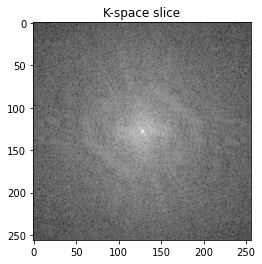

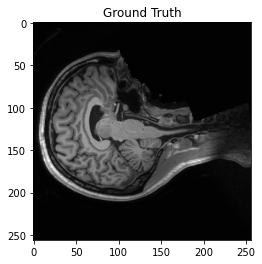

In [22]:
slicenu = 88-5
slice_ksp = kspace_np[:,:,slicenu]
plt.imshow(20*np.log(np.abs(slice_ksp)),cmap='gray')
plt.title('K-space slice')
plt.figure()
plt.imshow(img_data_arr[:,:,slicenu],cmap='gray')
plt.title('Ground Truth')
print("Kspace shape (x, y, number slices, number coils): ", (kspace_np.shape ,1))

In [23]:
slice_ksp = slice_ksp[np.newaxis,:]
slice_ksp_torchtensor = transform.to_tensor(slice_ksp)

In [10]:
slice_ksp_torchtensor.shape

torch.Size([1, 256, 256, 2])

In [11]:
desired_factor = 2 # desired under-sampling factor
undersampling_factor = 0
tolerance = 0.5
while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
  mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
  masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
  mask1d = var_to_np(mask)[0,:,0]
  #mask1d = (var_to_np(mask)).reshape((256,))
  undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]
#mask1d = (var_to_np(mask)).reshape((256,))

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()
print("under-sampling factor:",round(len(mask1d)/sum(mask1d),2))

under-sampling factor: 11.64


In [12]:
mask.shape

torch.Size([1, 1, 256, 1])

Text(0.5, 1.0, 'Masked Kspace-Slice')

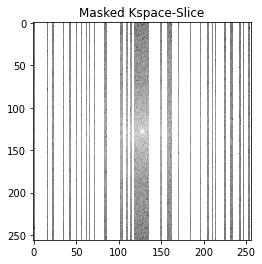

In [13]:
plt.imshow(20*np.log(torch.abs(masked_kspace[0,:,:,1])),cmap='gray')
plt.title('Masked Kspace-Slice')

In [14]:
from demo_helper import helpers

def fft2(data):
  data = helpers.fft2(data)
  return data


def ifft2(data):
  data = helpers.ifft2(data)
  return data


def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3, 0)) )   

def lsreconstruction(measurement,mode='both'):
    # measurement has dimension (1, num_slices, x, y, 2)
    fimg = ifft2(measurement)
    normimag = torch.norm(fimg[:,:,:,:,0])
    normreal = torch.norm(fimg[:,:,:,:,1])
    #print("real/img parts: ",normimag, normreal)
    if mode == 'both':
        return torch.sqrt(fimg[:,:,:,:,0]**2 + fimg[:,:,:,:,1]**2)
    elif mode == 'real':
        return torch.tensor(fimg[:,:,:,:,0]) #torch.sqrt(fimg[:,:,:,:,0]**2)
    elif mode == 'imag':
        return torch.sqrt(fimg[:,:,:,:,1]**2)

def get_scale_factor_me(net,num_channels,in_size,slice_ksp,scale_out=1,scale_type="norm"): 
    ### get norm of deep decoder output
    # get net input, scaling of that is irrelevant
    shape = [1,num_channels, in_size[0], in_size[1]]
    ni = Variable(torch.zeros(shape)).type(dtype)
    ni.data.uniform_()
    # generate random image
    try:
        out_chs = net( ni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
    except:
        out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
    out_imgs = channels2imgs(out_chs)
    out_img_tt = transform.root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

    ### get norm of least-squares reconstruction
    ksp_tt = transform.to_tensor(slice_ksp)
    print(ksp_tt.shape)
    orig_tt = ifft2(ksp_tt)           # Apply Inverse Fourier Transform to get the complex image
    orig_imgs_tt = transform.complex_abs(orig_tt)   # Compute absolute value to get a real image
    orig_img_tt = transform.root_sum_of_squares(orig_imgs_tt, dim=0)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    if scale_type == "norm":
        s = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    if scale_type == "mean":
        s = (out_img_tt.mean() / orig_img_np.mean()).numpy()[np.newaxis][0]
    return s,ni

In [15]:
def data_consistency(parnet, parni, mask1d, slice_ksp):
    img = parnet(parni.type(dtype))
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    # ksp has dim: (num_slices,x,y)
    meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
    meas = meas.type(dtype)
    
    mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
    ksp_dc = Fimg.clone()
    #ksp_dc = ksp_dc.detach().cpu()
    ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

    img_dc = ifft2(ksp_dc)[0]
    
    out = []
    for img in img_dc.detach().cpu():
        out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

    par_out_chs = np.array(out)
    #par_out_chs = parnet( parni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
    par_out_imgs = channels2imgs(par_out_chs)
    plt.imshow((par_out_imgs[0]).astype(np.uint8),cmap='gray')
    prec = crop_center2(root_sum_of_squares2(par_out_imgs),320,320)
    return prec

In [18]:
slice_ksp.shape

(256,)

In [17]:
img = parnet(parni.type(dtype))
s = img.shape
ns = int(s[1]/2) # number of slices
fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
for i in range(ns):
    fimg[0,i,:,:,0] = img[0,2*i,:,:]
    fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    # ksp has dim: (num_slices,x,y)
meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
meas = meas.type(dtype)
    
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
ksp_dc = Fimg.clone()
    #ksp_dc = ksp_dc.detach().cpu()
ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

img_dc = ifft2(ksp_dc)[0]
    
out = []
for img in img_dc.detach().cpu():
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]


ValueError: axes don't match array

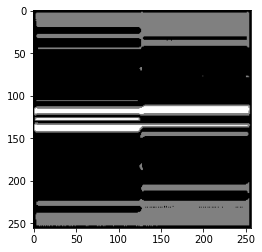

In [60]:
plt.imshow((par_out_imgs[0]).astype(np.uint8),cmap='gray')

In [49]:
ksp_dc.shape

torch.Size([1, 1, 256, 256, 2])

In [40]:
lsreconstruction(img)

torch.Size([1, 256, 256, 2])

In [31]:
ksp_dc.device

device(type='cuda', index=0)

In [28]:
meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
meas = meas.type(dtype)

mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))

In [29]:
meas.device

device(type='cuda', index=0)

# Loading MRI measurement

### Setup and fit ConvDecoder

In [19]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]
print(f'output_depth, output_size: {output_depth,out_size}')

output_depth, output_size: (2, (256, 256))


In [27]:
arch_name = "ConvDecoder"
###
num_channels = 256
num_layers = 8
strides = [1]*(num_layers-1)
in_size = [256,256]
kernel_size = 3
net = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=False, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

[(256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]
#prameters of ConvDecoder: 4723200


In [28]:
scale_out = 1
scaling_factor,ni = get_scale_factor_me(net,
                                       num_channels,
                                       in_size,
                                       slice_ksp,
                                       scale_out=scale_out)

torch.Size([1, 256, 256, 2])


In [29]:
def forwardm_me(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg


In [30]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor
    ### mask the ksapce
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image2 = (ifft2(masked_kspace))
    
measurement = ksp2measurement(slice_ksp).type(dtype)
lsimg = lsreconstruction(measurement)
    
    ### fit the network to the under-sampled measurement
out = []
for img in sampled_image2:
  out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [31]:
sampled_image2.shape

torch.Size([1, 256, 256, 2])

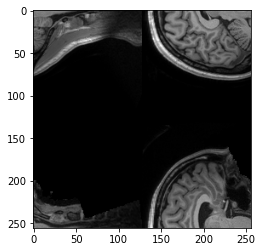

In [32]:
plt.imshow(lsimg[0,0,:,:].detach().cpu(),cmap='gray')

In [34]:
num_iter =20000
LR = 0.008
scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,num_channels=[num_channels]*(num_layers-1),
                                                                num_iter=num_iter,
                                                                LR=LR,
                                                                mask = mask2d,
                                                                apply_f = forwardm_me,
                                                                img_noisy_var=unders_measurement,
                                                                net=net,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                #lsimg = lsimg,
                                                                find_best=True,
                                                                loss_type="MSE",
                                                                scale_out=scale_out,
                                                                net_input = slice_ksp_torchtensor,
                                                                OPTIMIZER = "adam")

input provided
optimize with adam 0.008


In [ ]:
data_consistency(parnet, parni, mask1d, slice_ksp)

In [43]:
tanvi = parnet.to(device='cpu')

In [44]:
janvi = parni.to(device='cpu')

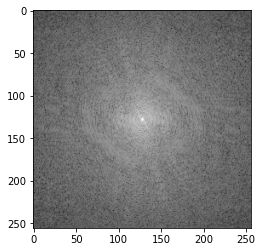

In [48]:
plt.imshow(20*np.log(np.abs(slice_ksp[0])),cmap='gray')

In [24]:
mask1d = np.load('mask.npy')

In [6]:
parnet = torch.load('full_model.pth')

In [12]:
parnet = parnet.to(device='cuda:0')
parni = parni.to(device='cuda:0')

In [7]:
parni = torch.load('model_input.pth')

In [53]:
torch.save(parnet.state_dict(), 'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/model.pth')

In [54]:
torch.save(parnet, 'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/full_model.pth')

In [56]:
torch.save(parni,'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/model_input.pth')

In [59]:
np.save('C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/mask.npy',mask1d)

In [50]:
parnet.type

<bound method Module.type of conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(256, 256), mode=nearest)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Upsample(size=(256, 256), mode=nearest)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Upsample(size=(256, 256), mode=nearest)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Upsample(size=(256, 256), mode=nearest)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): BatchNorm2d(256

In [35]:
parnet, parni, slice_ksp

(conv_model(
   (act_fun): ReLU()
   (net1): Sequential(
     (1): Upsample(size=(256, 256), mode=nearest)
     (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (3): ReLU()
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): Upsample(size=(256, 256), mode=nearest)
     (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): ReLU()
     (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): Upsample(size=(256, 256), mode=nearest)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (11): ReLU()
     (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (13): Upsample(size=(256, 256), mode=nearest)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (15): ReLU()
     (16): BatchNorm2d(256, eps=1e-0

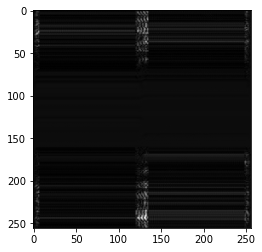

In [25]:
rec_convD = data_consistency(parnet, parni, mask1d, slice_ksp)

In [34]:
rec_convD.shape

(32, 32)

### Setup and fit Deep Decoder (DD)

In [119]:
### delete cashe
#del(net,ni)
torch.cuda.empty_cache()

In [120]:
arch_name = "DD"
###
num_channels = 368
num_layers = 10
in_size = [16,16]

net = skipdecoder(out_size,in_size,output_depth,
                   num_layers,num_channels,skips=False,need_last=True,
                   need_sigmoid=False,upsample_mode="bilinear").type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

[(22, 22), (30, 30), (41, 41), (55, 55), (75, 75), (102, 102), (139, 139), (189, 189), (256, 256)]
#prameters of DD: 1362336


In [121]:
net,ni,slice_ksp_cd = fit_untrained(net, num_channels, mask, in_size, slice_ksp, slice_ksp_torchtensor)

torch.Size([1, 256, 256, 2])
input provided
optimize with adam 0.008


RuntimeError: ignored

In [10]:
rec_DD = data_consistency(net, ni, mask1d, slice_ksp_cd)

NameError: name 'net' is not defined

### Setup and fit Deep Image Prior (DIP) (encoder-decoder style architecture)

In [ ]:
### delete cashe
del(net,ni)
torch.cuda.empty_cache()

In [ ]:
arch_name = "DIP"
### 
in_size = slice_ksp.shape[-2:]
pad = "zero" #'reflection' # 'zero'
num_channels = 256
net = skip(in_size,num_channels, output_depth, 
           num_channels_down = [num_channels] * 8,
           num_channels_up =   [num_channels] * 8,
           num_channels_skip =    [num_channels*0] * 6 + [4,4],  
           filter_size_up = 3, filter_size_down = 5, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='ReLU').type(dtype)
print("#prameters of {}:".format(arch_name),num_param(net))
#print(net)

#prameters of DIP: 31514182


In [ ]:
net,ni,slice_ksp_cd = fit_untrained(net, num_channels, mask, in_size, slice_ksp, slice_ksp_tensor)

AttributeError: ignored

In [ ]:
rec_DIP = data_consistency(net, ni, mask1d, slice_ksp_cd)

### Evaluation

In [ ]:
def scores(im1,im2):
    im1 = (im1-im1.mean()) / im1.std()
    im1 *= im2.std()
    im1 += im2.mean()
    
    vif_ = vifp_mscale(im1,im2,sigma_nsq=im1.mean())
    
    ssim_ = ssim(np.array([im1]), np.array([im2]))
    psnr_ = psnr(np.array([im1]),np.array([im2]))

    dt = torch.FloatTensor
    im11 = torch.from_numpy(np.array([[im1]])).type(dt)
    im22 = torch.from_numpy(np.array([[im2]])).type(dt)
    ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]
    return vif_, ms_ssim_, ssim_, psnr_

In [ ]:
gt = f["reconstruction_rss"][slicenu]

In [ ]:
vif_cd, ms_ssim_cd, ssim_cd, psnr_cd  = scores(gt, rec_convD)
vif_dd, ms_ssim_dd, ssim_dd, psnr_dd  = scores(gt, rec_DD)
vif_dip, ms_ssim_dip, ssim_dip, psnr_dip  = scores(gt, rec_DIP)

### Visualization

ConvDecoder       --> VIF: 0.63, MS-SSIM: 0.94, SSIM: 0.75, PSNR: 31.62 
Deep Decoder      --> VIF: 0.62, MS-SSIM: 0.86, SSIM: 0.67, PSNR: 29.14 
Deep Image Prior  --> VIF: 0.54, MS-SSIM: 0.88, SSIM: 0.42, PSNR: 25.99 


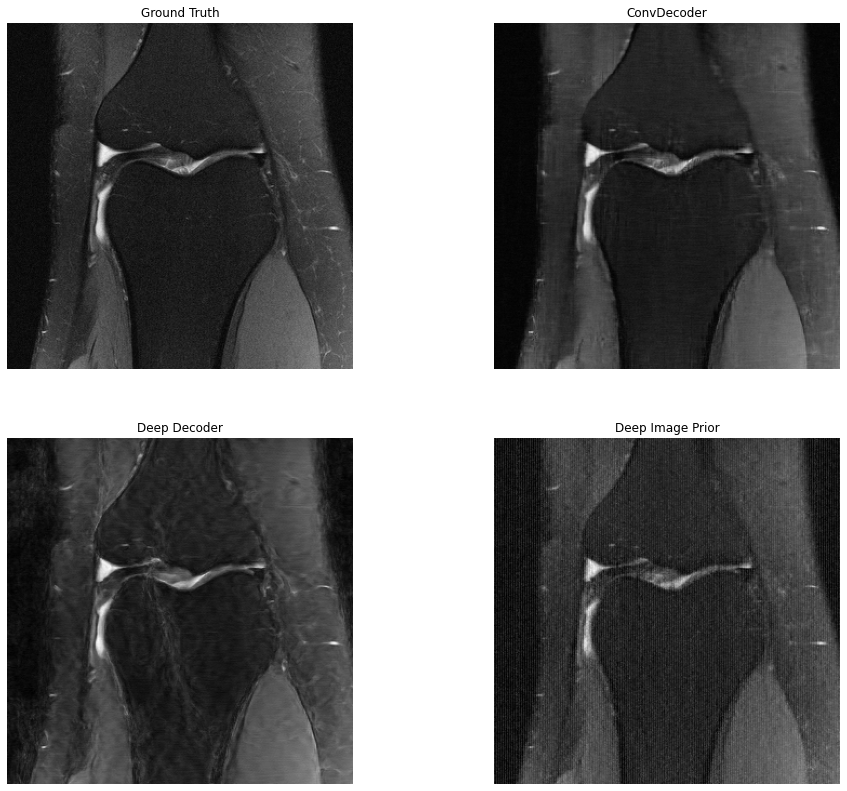

In [ ]:
fig = plt.figure(figsize = (16,14)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(221)
ax1.imshow(gt,cmap='gray')
ax1.set_title('Ground Truth')
ax1.axis('off')

ax2 = fig.add_subplot(222)
ax2.imshow(rec_convD,cmap='gray')
ax2.set_title( "ConvDecoder") 
ax2.axis('off') 

ax3 = fig.add_subplot(223)
ax3.imshow(rec_DD,cmap='gray')
ax3.set_title( "Deep Decoder" ) 
ax3.axis('off')

ax4 = fig.add_subplot(224)
ax4.imshow(rec_DIP,cmap='gray')
ax4.set_title( "Deep Image Prior" ) 
ax4.axis('off')

print("ConvDecoder       --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_cd,ms_ssim_cd,ssim_cd,psnr_cd))
print("Deep Decoder      --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_dd,ms_ssim_dd,ssim_dd,psnr_dd))
print("Deep Image Prior  --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_dip,ms_ssim_dip,ssim_dip,psnr_dip))

plt.show()